In [ ]:

import os
import shutil
from tensorflow.keras.utils import to_categorical
import time
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from tensorflow.keras.models import load_model
import re

from matplotlib import pyplot as plt

from numpy.random import seed
import tensorflow as tf
from tensorflow.keras import backend as k
import os
import PIL
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
pathToImages = '/content/gdrive/MyDrive/TFM/data/set'
dirname = os.path.join(os.getcwd(), pathToImages)
imgpath = dirname + os.sep 
 
images = []
directories = []
dircount = []
prevRoot=''
cant=0

img_height = 400
img_width = 600
channel = 1
 
print("leyendo imagenes de ",imgpath)
 
for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            #image = plt.imread(filepath)
            image=cv2.resize(cv2.imread(filepath, cv2.IMREAD_GRAYSCALE), (img_width, img_height), interpolation = cv2.INTER_AREA)
            #plt.imshow(image)
            #cv2.waitkey(0)
            image_array = img_to_array(image)
            images.append(image_array)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

 
dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  /content/gdrive/MyDrive/TFM/data/set/
/content/gdrive/MyDrive/TFM/data/set/front 1
/content/gdrive/MyDrive/TFM/data/set/back 288
/content/gdrive/MyDrive/TFM/data/set/error 287
/content/gdrive/MyDrive/TFM/data/set/passport 163
Directorios leidos: 4
Imagenes en cada directorio [289, 287, 163, 179]
suma Total de imagenes en subdirs: 918


In [ ]:
from keras.utils import np_utils
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))
 
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1


X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
X = X.astype('float32')
targets=np.array(labels)#.astype('float32')
y = np_utils.to_categorical(targets) 
num_classes= y.shape[1]

del images
 
train_generator = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        rescale = 1. / 255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')

valid_generator = ImageDataGenerator(rescale = 1. / 255) 

Cantidad etiquetas creadas:  918
0 front
1 back
2 error
3 passport


In [ ]:
''' Funcion para visualizar los resultados '''    
def plot_graphs(cnn):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure().set_size_inches(20, 8)
    
    # Accuracy vs Validation Accuracy
    plt.subplot(1, 2, 1)
    #plt.figure(0)
    plt.plot(cnn.history['accuracy'],'r')
    plt.plot(cnn.history['val_accuracy'],'g')
    plt.xticks(np.arange(0, epochs, 10))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy / Loss")
    plt.title("Accuracy vs Loss")
    plt.legend(['acc','val_acc'])
    plt.ylim(0, 1.01)
    #plt.show()

    # Loss vs Validation Loss
    plt.subplot(1, 2, 2)
    #plt.figure(1)
    plt.plot(cnn.history['loss'],'b', linestyle = '--')
    plt.plot(cnn.history['val_loss'],'y', linestyle = '--')
    plt.xticks(np.arange(0, epochs, 10))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.legend(['train','validation'])
    plt.show()

In [ ]:
def createModel():
    model= Sequential()
            #n mapas #filtro
    model.add(Conv2D(16,(5,5),input_shape=(img_height,img_width,channel),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(32,(5,5),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64,(5,5),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(528,activation='relu'))
    model.add(Dense(342,activation='relu'))
    model.add(Dense(128,activation='relu'))
    #capa de salida (Si fuera binaria
    #model.add(Dense(1,activation='sigmoid')) #binaria
    #model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) #binaria
    #capa de salida
    model.add(Dense(num_classes,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
''' PROBANDO VERSIONES MAS OPTIMAS '''
def createModel():
  model= Sequential()
          #n mapas #filtro
  model.add(Conv2D(16,(5,5),input_shape=(img_height,img_width,channel),activation='relu'))
  model.add(MaxPooling2D())
  model.add(Conv2D(32,(5,5),activation='relu'))
  model.add(MaxPooling2D())
  model.add(Conv2D(64,(5,5),activation='relu'))
  model.add(MaxPooling2D())
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(64,activation='relu'))
  model.add(Dense(32,activation='relu'))
  # #capa de salida (Si fuera binaria
  # #model.add(Dense(1,activation='sigmoid')) #binaria
  # #model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) #binaria
  # #capa de salida
  model.add(Dense(num_classes,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
  #model.summary()

  return model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


accuracy: 93.48%


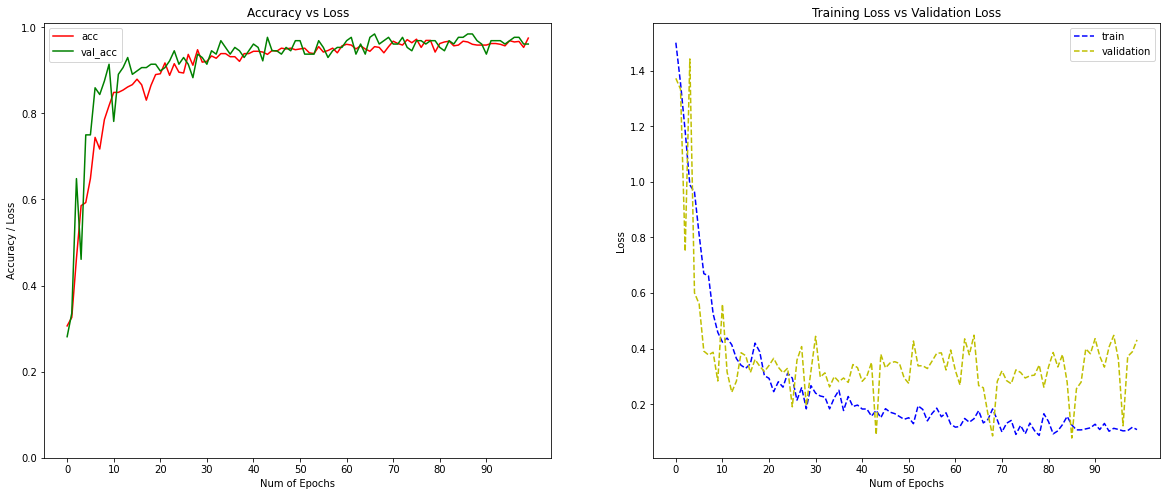

Accuracy:  0.9347826086956522


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


accuracy: 93.48%


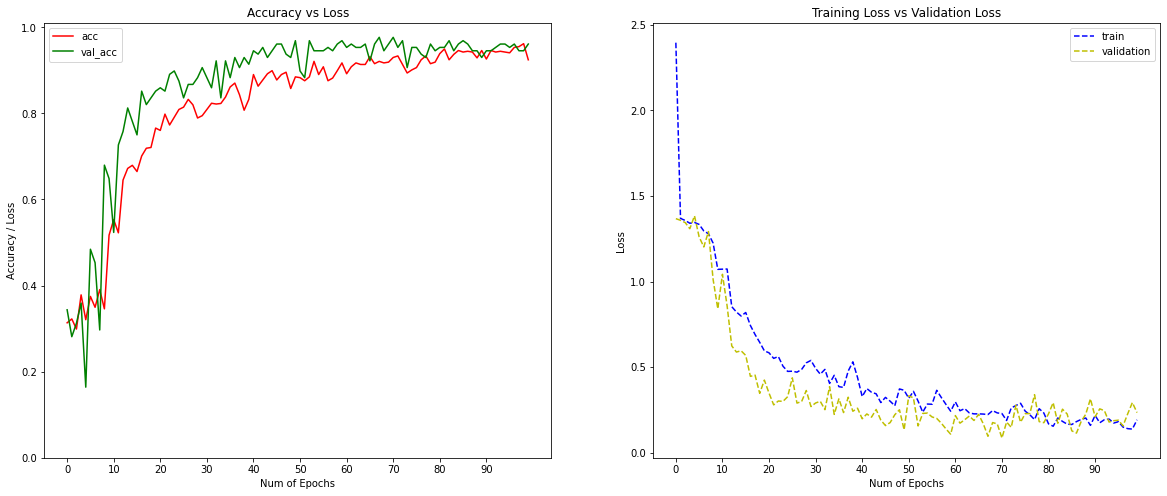

Accuracy:  0.9347826086956522


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


accuracy: 95.11%


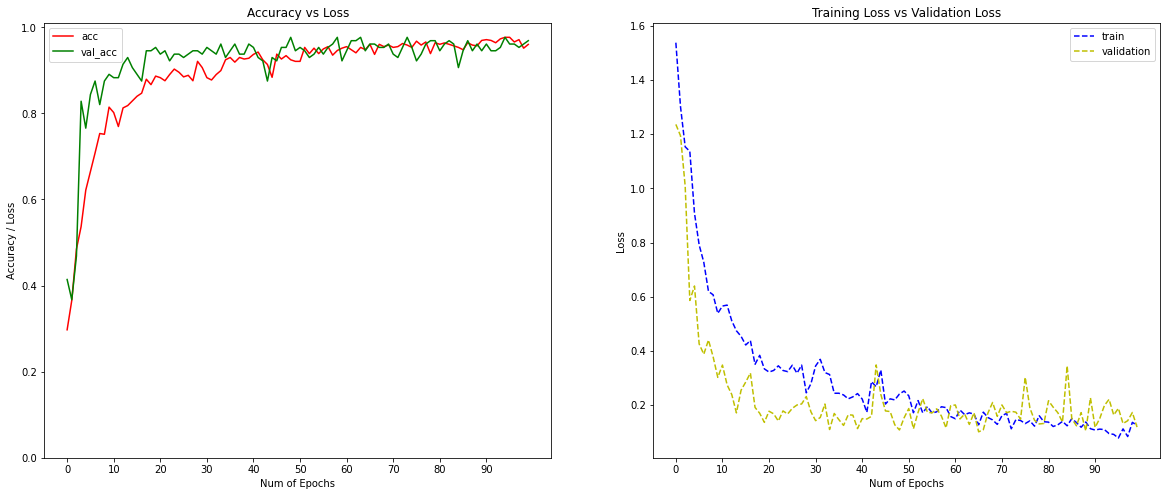

Accuracy:  0.9510869565217391


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


accuracy: 95.08%


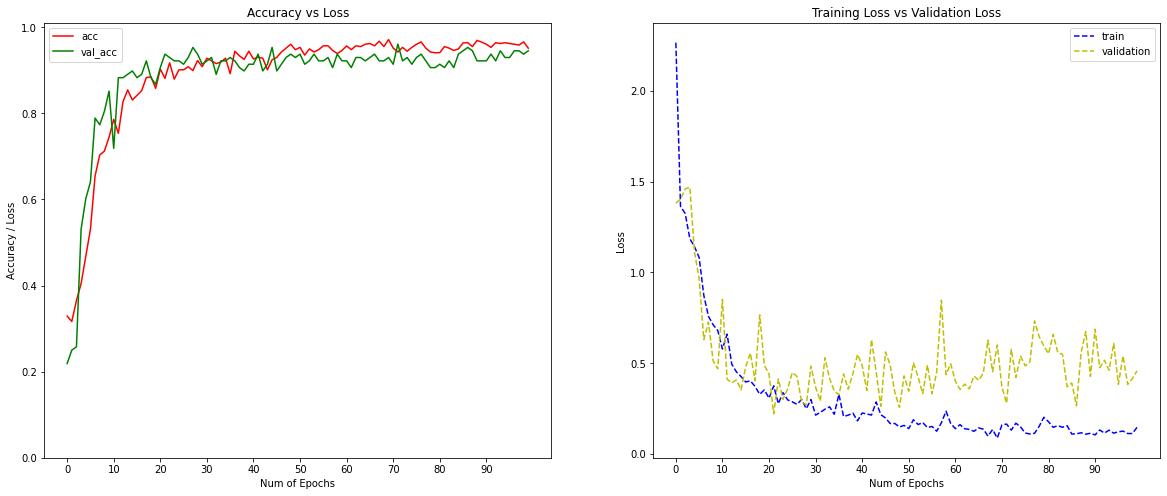

Accuracy:  0.9508196721311475


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


accuracy: 95.63%


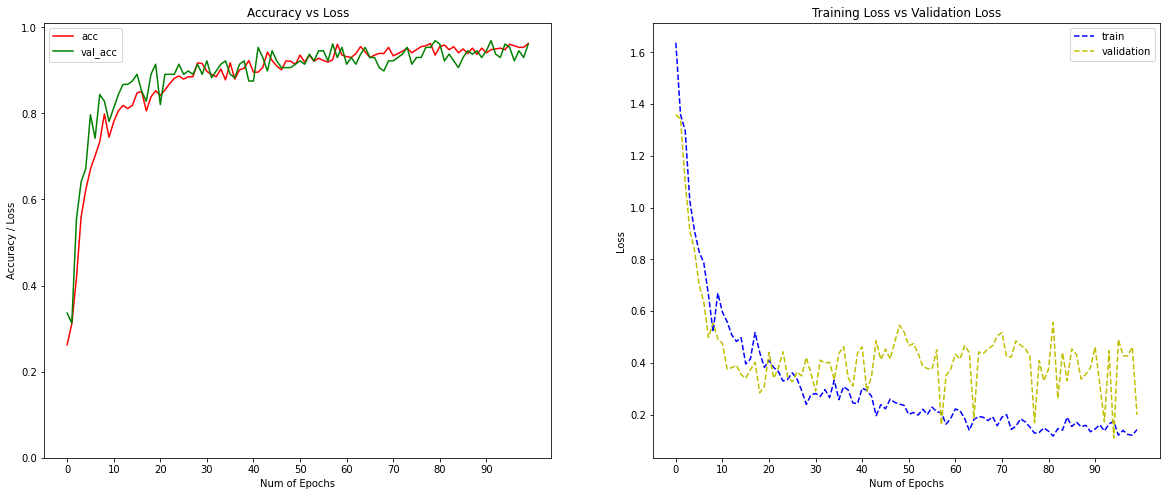

Accuracy:  0.9562841530054644
confussion matrix:
[[56  0  1  0]
 [ 0 58  0  0]
 [ 2  2 26  2]
 [ 1  0  0 35]]
94.56% (+/- 0.90%)
Time: 4216.00 sec
listo


In [ ]:
# FIRST EXECUTION ONLY 64 DENSE LAYERS 
start = time.time()

#Definimos el K fold, importante, creo que automaticamente da un 70/30 para train y test
kfold= StratifiedKFold(n_splits=5,shuffle=True)
cvscores = []
resultados = []

for train,test in kfold.split(X,labels):
    #definimos el modelo keras

    #De los datos para entrenamiento, saco para la validacion
    X_train,X_validation,y_train,y_validation = train_test_split(X[train],y[train],test_size=0.20) 
    # Entrenar
    # model.fit(X[train],y[train],epochs=10,batch_size=10,verbose=1) <---- si no tuviera conjunto para validacion
    # verbose=0 no muestra paso por paso
    batch_size = 32
    epochs = 100
    model = createModel()
    model_t = model.fit_generator(train_generator.flow(X_train, y_train, batch_size=batch_size, shuffle = True), steps_per_epoch=len(X_train) // batch_size, epochs=epochs, verbose=0, validation_data=valid_generator.flow(X_validation, y_validation, shuffle = True), validation_steps=len(X_validation) // batch_size)

    #model.fit(X_train,y_train,validation_data=(X_validation,y_validation),epochs=10,batch_size=20,verbose=0)# training / validation
    # Evaluar
    scores=model.evaluate(X[test],y[test],verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1],scores[1]*100))
    cvscores.append(scores[1]*100)

    from sklearn.metrics import confusion_matrix, accuracy_score
    predictions = model.predict(X[test], steps=len(X[test]), verbose=0)
    y_pred = np.argmax(predictions, axis=-1)
    y_true=np.argmax(y[test], axis=-1)

    cm = confusion_matrix(y_true, y_pred)

    plot_graphs(model_t)
    
    previsoes = model.predict(X[test])
    previsoes = (previsoes > 0.5) # Se a saida for > 0.5 -> classe 1 senão classe 0
    accuracy = accuracy_score(y[test], previsoes)
    print('Accuracy: ', accuracy)

    resultados.append(accuracy)

print('confussion matrix:')
print(cm)

print("%.2f%% (+/- %.2f%%)" %(np.mean(cvscores),np.std(cvscores)))
#print(model.metrics_names)

done = time.time()
elapsed = done - start

print("Time: %0.2f sec"%(elapsed))

print('listo')

In [ ]:
#clases de modelo de 150 megas con imagenes de 400x600
print(deportes)

['front', 'back', 'error', 'passport']


Text(0.5, 1.0, 'Refined Confusion Matrix')

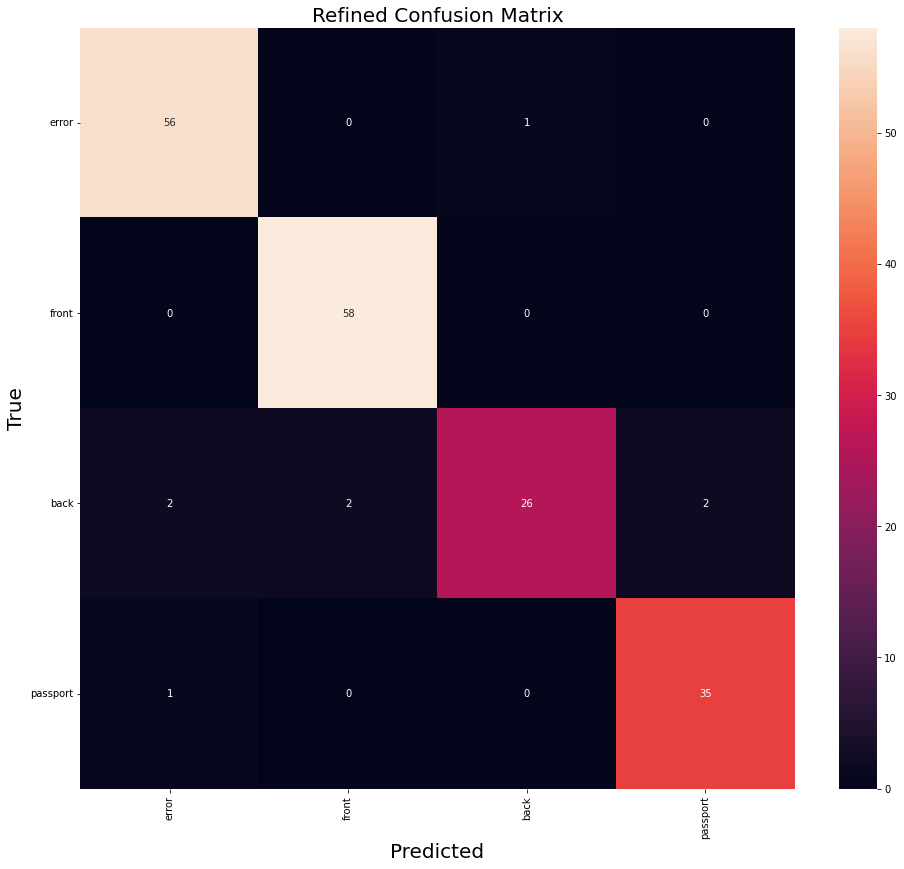

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['error', 'front', 'back', 'passport']
# cm = [[28, 3, 0, 1],
#  [1, 57, 0, 0],
#  [0, 0, 57, 0],
#  [0, 0, 0, 36]]

'''
MATRIZ DE CONFUSION 
'''

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)



Confusion matrix, without normalization


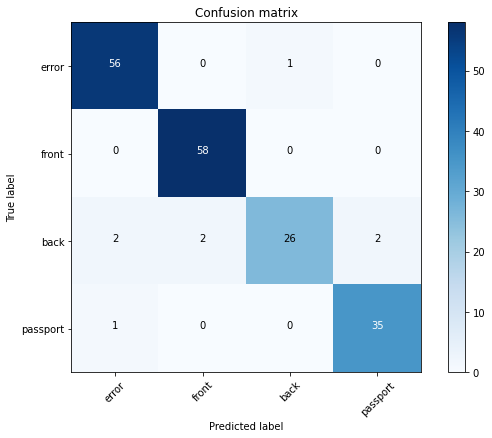

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(np.asarray(cm), class_names)    

In [ ]:
path_to_save =  '/content/gdrive/MyDrive/TFM/modelos/'
model.save(path_to_save+'06_10_22/two_layers_400x600.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


accuracy: 97.28%


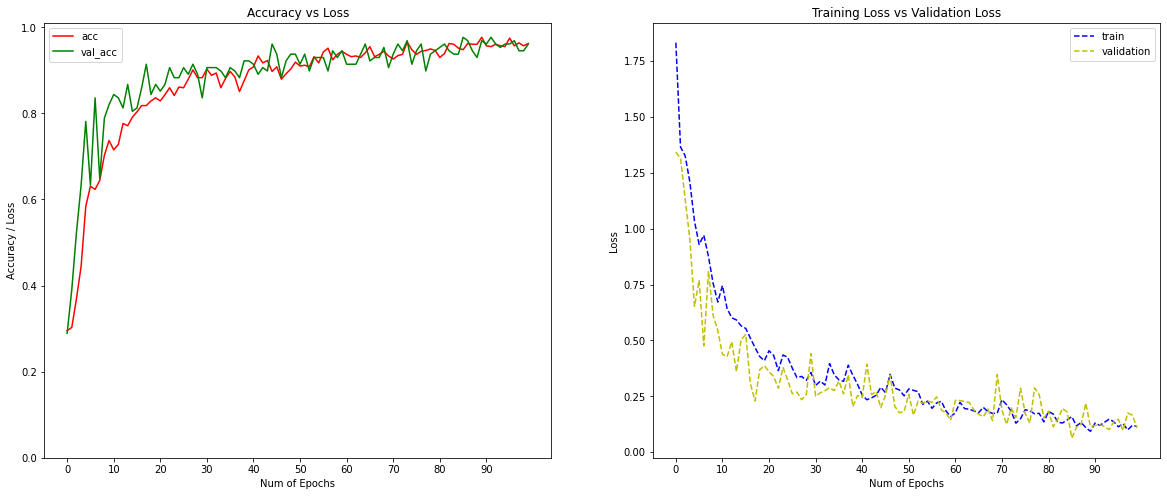

Accuracy:  0.9728260869565217


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


accuracy: 85.87%


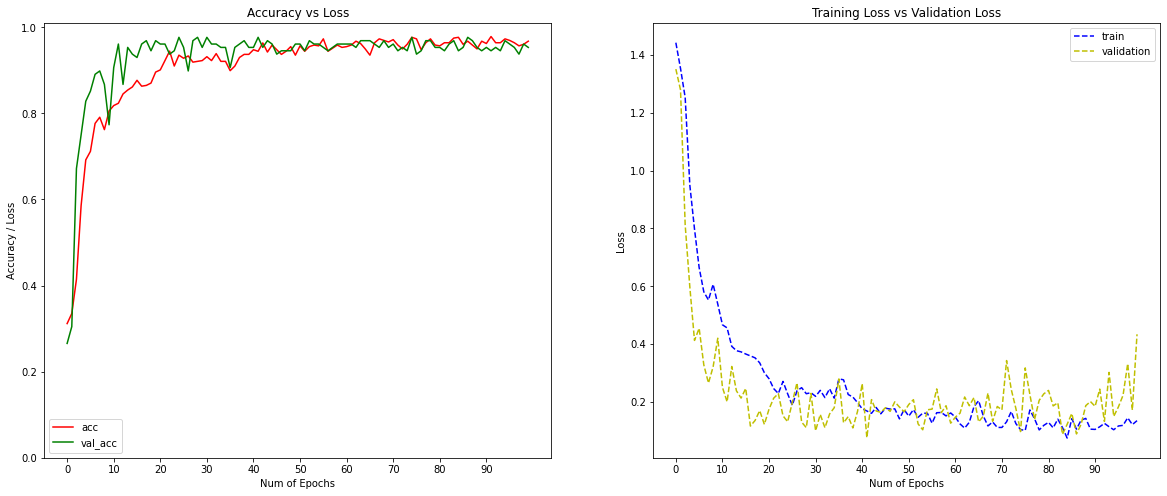

Accuracy:  0.8586956521739131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


accuracy: 96.20%


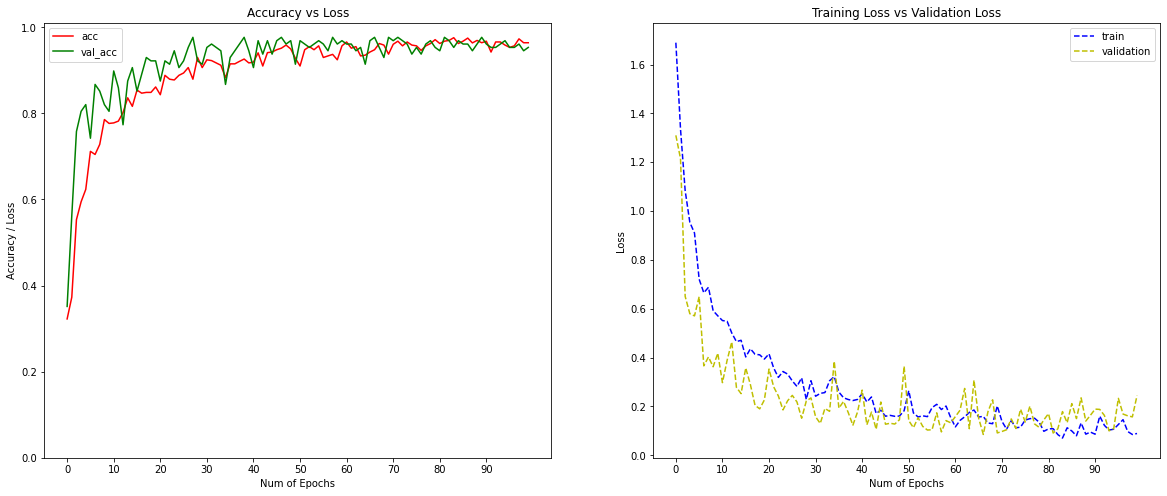

Accuracy:  0.9619565217391305


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


accuracy: 94.54%


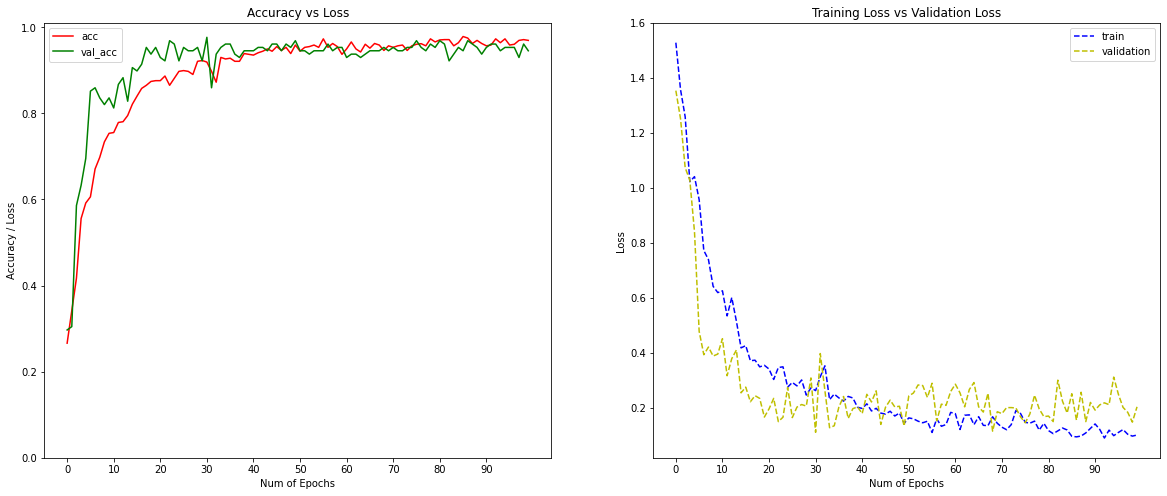

Accuracy:  0.9453551912568307


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


accuracy: 96.17%


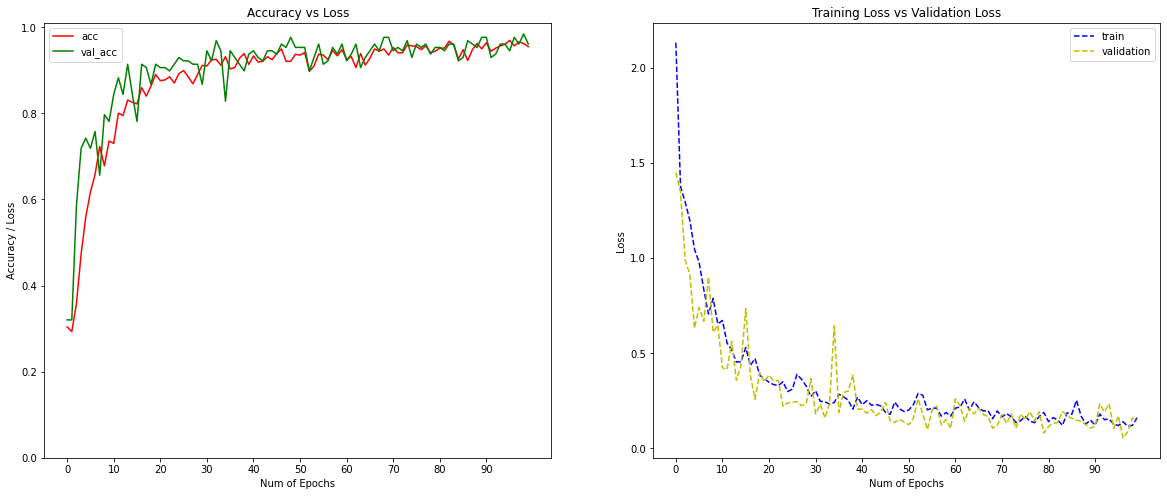

Accuracy:  0.9617486338797814
confussion matrix:
[[57  0  0  0]
 [ 0 58  0  0]
 [ 5  0 25  2]
 [ 0  0  0 36]]
94.01% (+/- 4.16%)
Time: 1620.30 sec
listo


In [ ]:
# ADDING 128 AND 64 DENSE LAYERS 
start = time.time()

#Definimos el K fold, importante, creo que automaticamente da un 70/30 para train y test
kfold= StratifiedKFold(n_splits=5,shuffle=True)
cvscores = []
resultados = []

for train,test in kfold.split(X,labels):
    #definimos el modelo keras

    #De los datos para entrenamiento, saco para la validacion
    X_train,X_validation,y_train,y_validation = train_test_split(X[train],y[train],test_size=0.20) 
    # Entrenar
    # model.fit(X[train],y[train],epochs=10,batch_size=10,verbose=1) <---- si no tuviera conjunto para validacion
    # verbose=0 no muestra paso por paso
    batch_size = 32
    epochs = 100
    model = createModel()
    model_t = model.fit_generator(train_generator.flow(X_train, y_train, batch_size=batch_size, shuffle = True), steps_per_epoch=len(X_train) // batch_size, epochs=epochs, verbose=0, validation_data=valid_generator.flow(X_validation, y_validation, shuffle = True), validation_steps=len(X_validation) // batch_size)

    #model.fit(X_train,y_train,validation_data=(X_validation,y_validation),epochs=10,batch_size=20,verbose=0)# training / validation
    # Evaluar
    scores=model.evaluate(X[test],y[test],verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1],scores[1]*100))
    cvscores.append(scores[1]*100)

    from sklearn.metrics import confusion_matrix, accuracy_score
    predictions = model.predict(X[test], steps=len(X[test]), verbose=0)
    y_pred = np.argmax(predictions, axis=-1)
    y_true=np.argmax(y[test], axis=-1)

    cm = confusion_matrix(y_true, y_pred)

    plot_graphs(model_t)
    
    previsoes = model.predict(X[test])
    previsoes = (previsoes > 0.5) # Se a saida for > 0.5 -> classe 1 senão classe 0
    accuracy = accuracy_score(y[test], previsoes)
    print('Accuracy: ', accuracy)

    resultados.append(accuracy)

print('confussion matrix:')
print(cm)

print("%.2f%% (+/- %.2f%%)" %(np.mean(cvscores),np.std(cvscores)))
#print(model.metrics_names)

done = time.time()
elapsed = done - start

print("Time: %0.2f sec"%(elapsed))

print('listo')

Text(0.5, 1.0, 'Refined Confusion Matrix')

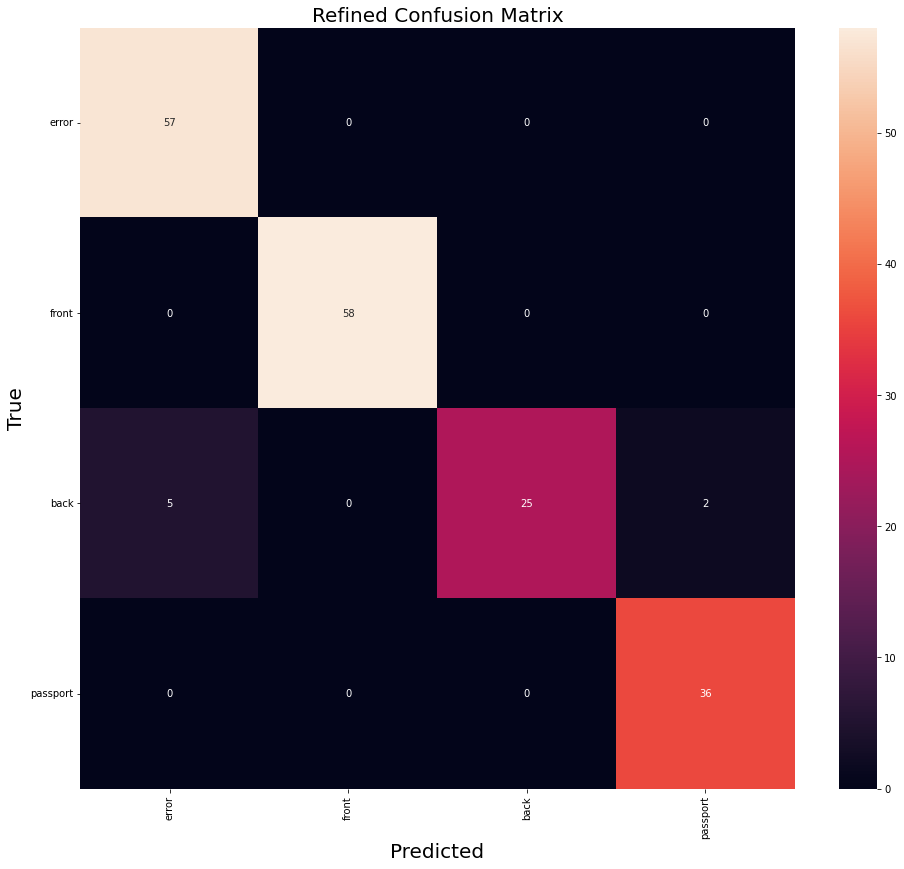

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['error', 'front', 'back', 'passport']
# cm = [[28, 3, 0, 1],
#  [1, 57, 0, 0],
#  [0, 0, 57, 0],
#  [0, 0, 0, 36]]

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)



In [ ]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 246, 346, 16)      416       
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 123, 173, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 119, 169, 32)      12832     
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 59, 84, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 55, 80, 64)        51264     
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 27, 40, 64)     

In [ ]:
path_to_save =  '/content/gdrive/MyDrive/TFM/modelos/'
model.save(path_to_save+'06_10_22/two_dense_layers.h5')

Text(0.5, 1.0, 'Refined Confusion Matrix')

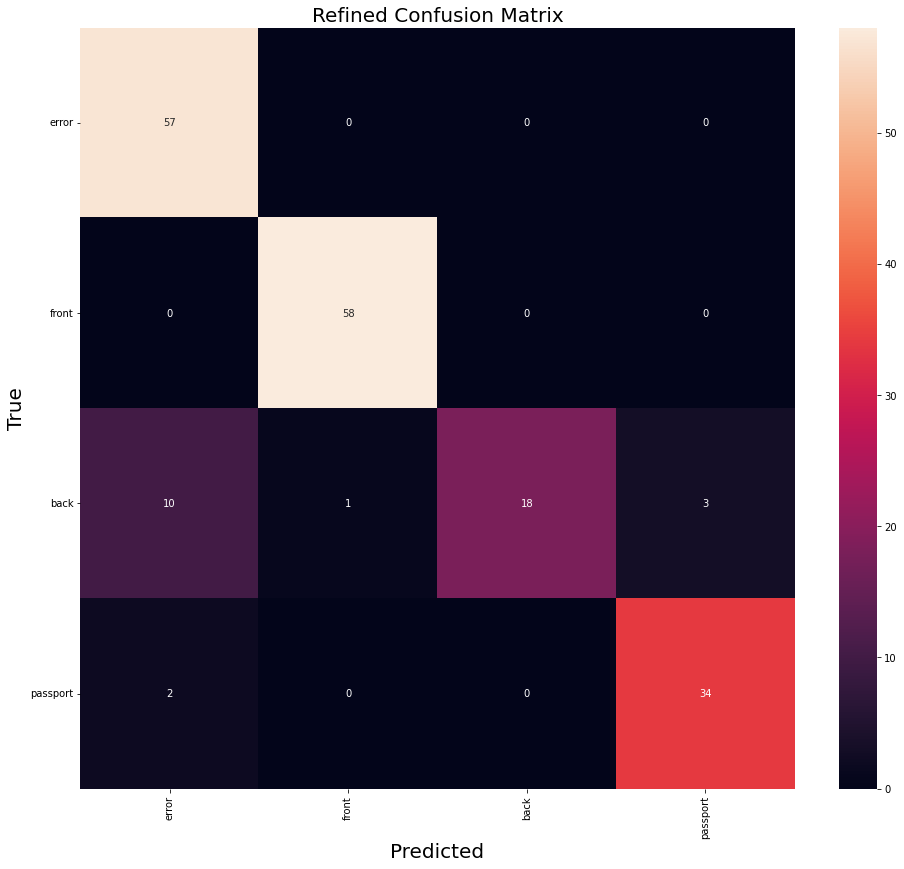

In [ ]:
''' === ONE DENSE LAYER RESULTS ==='''
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['error', 'front', 'back', 'passport']
# cm = [[28, 3, 0, 1],
#  [1, 57, 0, 0],
#  [0, 0, 57, 0],
#  [0, 0, 0, 36]]

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)



Confusion matrix, without normalization


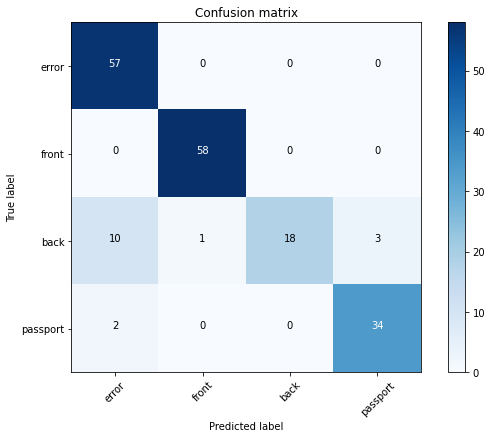

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(np.asarray(cm), class_names)    

Text(0.5, 1.0, 'Refined Confusion Matrix')

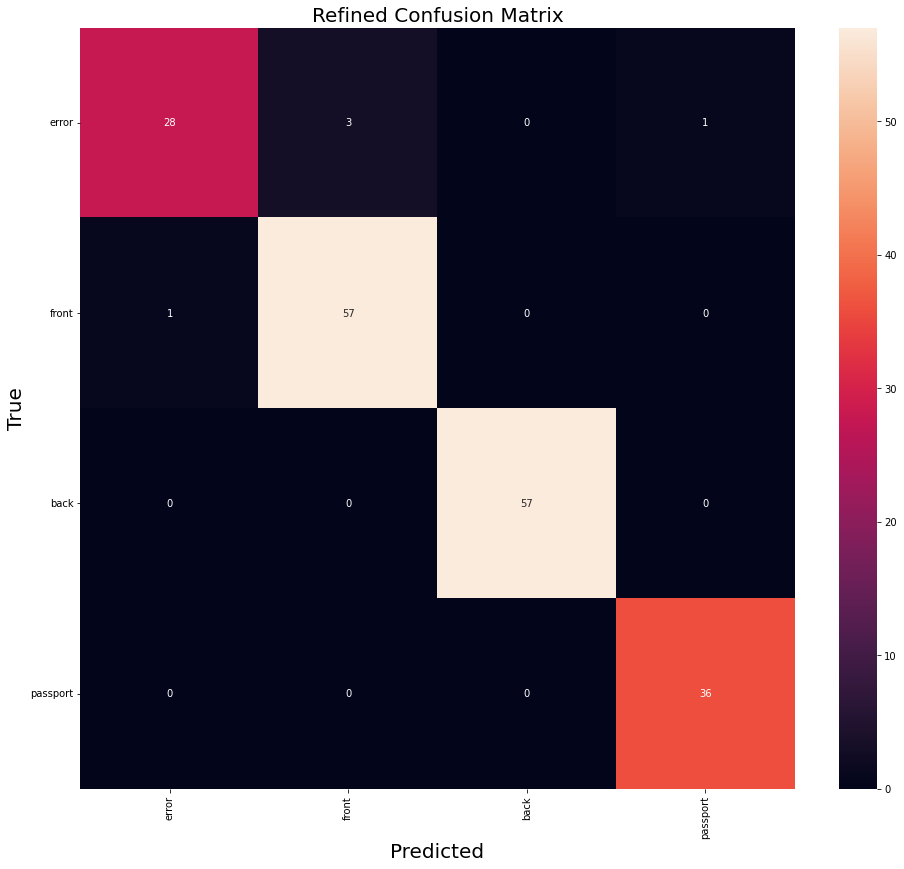

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['error', 'front', 'back', 'passport']
# cm = [[28, 3, 0, 1],
#  [1, 57, 0, 0],
#  [0, 0, 57, 0],
#  [0, 0, 0, 36]]

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

Confusion matrix, without normalization


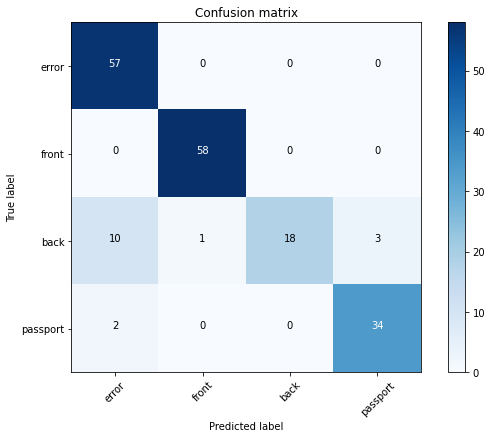

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(np.asarray(cm), class_names)    

In [ ]:
print(deportes)

['front', 'back', 'error', 'passport']


In [ ]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
import PIL

from google.colab import drive
drive.mount('/content/gdrive')

#sport_model.save(path+"firstModel_mnist.h5py")
path =  '/content/gdrive/MyDrive/TFM/'

#modelt = load_model(path+"modelos/kfold_model_trained_97_26_Acc.h5")
modelt = load_model(path+"modelos/now.h5")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
import PIL

from google.colab import drive
drive.mount('/content/gdrive')

#sport_model.save(path+"firstModel_mnist.h5py")
path =  '/content/gdrive/MyDrive/TFM/'

#modelt = load_model(path+"modelos/kfold_model_trained_97_26_Acc.h5")
bigModel = load_model(path+"modelos/LAST_new_model_trained.h5")
lowModel = load_model(path+"modelos/06_10_22/two_layers_400x600.h5")
#modelt = custom_vgg_model
#model.summary()


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


error


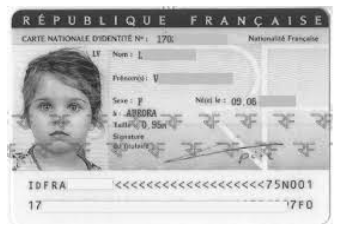

In [ ]:
"""=== BIG MODEL ==="""
##Esta imagen no forma parte del dataset
path = "/content/gdrive/MyDrive/TFM/data/set/"
names = ['passport', 'back', 'error', 'front']

filepath = path+"back/Selección_279.png"
filepath = "/content/gdrive/MyDrive/TFM/data/prueba/images.jpeg"
image=cv2.resize(cv2.imread(filepath, cv2.IMREAD_GRAYSCALE), (600, 400), interpolation = cv2.INTER_AREA)
xt = np.asarray(image)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds1 = bigModel.predict(xt)

print(names[np.argmax(preds1)])
plt.imshow(cv2.cvtColor(np.asarray(image),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

front


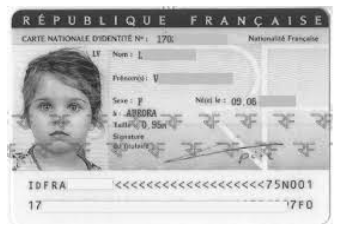

In [ ]:
"""=== LOW MODEL ==="""
##Esta imagen no forma parte del dataset
path = "/content/gdrive/MyDrive/TFM/data/set/"
names = ['front', 'back', 'error', 'passport']

filepath = "/content/gdrive/MyDrive/TFM/data/prueba/images.jpeg"
image=cv2.resize(cv2.imread(filepath, cv2.IMREAD_GRAYSCALE), (600, 400), interpolation = cv2.INTER_AREA)
xt = np.asarray(image)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds1 = lowModel.predict(xt)

print(names[np.argmax(preds1)])
plt.imshow(cv2.cvtColor(np.asarray(image),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()